# Open in Colab Badge and Runtime Detection

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/piumalnipun9/Inventory-Management-Forecasting-using-Machine-Learning/blob/main/notebooks/colab_run.ipynb)

This notebook lets you edit locally in VS Code while executing on a Google Colab runtime via a secure tunnel, and also provides robust loading/cleaning for `Grocery_Inventory_new_v1.csv`.

COLAB = False
try:
    import google.colab  # type: ignore
    COLAB = True
except Exception:
    COLAB = False
print(f"Running in Colab: {COLAB}")


In [1]:
# Install and Import Dependencies

import sys, os, subprocess, textwrap, random, string, json, time, io, re
from datetime import datetime, timedelta

# Minimal set here; the repo's requirements.txt will be installed if in Colab.
if 'google.colab' in sys.modules:
    %pip -q install --upgrade pip
    %pip -q install pandas pyarrow numpy seaborn matplotlib cloudflared jinja2
    # Also install project requirements if present
    REPO_URL = 'https://github.com/piumalnipun9/Inventory-Management-Forecasting-using-Machine-Learning.git'
    WORKDIR = '/content/Inventory-Management-Forecasting-using-Machine-Learning'
    if not os.path.exists(WORKDIR):
        !git clone --depth=1 $REPO_URL $WORKDIR
    else:
        %cd $WORKDIR
        !git pull --rebase --autostash
        %cd -
    REQ = os.path.join(WORKDIR, 'requirements.txt')
    if os.path.exists(REQ):
        %pip -q install -r $REQ

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4)
print('Dependencies ready')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'cloudflared' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'cloudflared'. Discussion can be found at https://github.com/pypa/pip/issues/6334
Cloning into '/content/Inventory-Management-Forecasting-using-Machine-Learning'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 0), reused 26 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 235.24 KiB | 6.72 MiB/s, done.
Dependencies ready


In [2]:
# Google Drive Auth/Mount (Colab) and Local/Upload Fallback


COLAB = 'google.colab' in sys.modules
UPLOADS = {}
DRIVE_MOUNT = '/content/drive'
if COLAB:
    try:
        from google.colab import drive, files  # type: ignore
        drive.mount(DRIVE_MOUNT, force_remount=False)
    except Exception as e:
        print('Drive mount skipped:', e)
    try:
        print('If your CSV is not on Drive, use the uploader below to select it from your computer...')
        UPLOADS = files.upload()  # opens a dialog in Colab UI
        print('Uploaded files:', list(UPLOADS.keys()))
    except Exception as e:
        print('Upload dialog not available or canceled:', e)
else:
    print('Running outside Colab; Drive mount and uploader are skipped.')


Mounted at /content/drive
If your CSV is not on Drive, use the uploader below to select it from your computer...


Saving Grocery_Inventory_new_v1.csv to Grocery_Inventory_new_v1.csv
Uploaded files: ['Grocery_Inventory_new_v1.csv']


In [3]:
# Robust CSV Loader for Grocery_Inventory_new_v1.csv


from pathlib import Path

def load_csv() -> Path | None:
    candidates = []
    # 1) Local Windows path as provided in VS Code workspace
    candidates.append(Path(r"e:/Web Development/Inventory_Manager/Grocery_Inventory_new_v1.csv"))
    candidates.append(Path(r"E:/Web Development/Inventory_Manager/Grocery_Inventory_new_v1.csv"))
    # 2) If running in Colab and Drive is mounted, look under MyDrive common locations
    if COLAB:
        drive_candidates = [
            Path(DRIVE_MOUNT) / 'MyDrive' / 'Grocery_Inventory_new_v1.csv',
            Path(DRIVE_MOUNT) / 'MyDrive' / 'Inventory' / 'Grocery_Inventory_new_v1.csv',
        ]
        candidates.extend(drive_candidates)
    # 3) Uploaded file in Colab
    if COLAB and UPLOADS:
        for name in UPLOADS.keys():
            if name.lower() == 'grocery_inventory_new_v1.csv':
                # Save uploaded content to the current working directory
                open(name, 'wb').write(UPLOADS[name])
                candidates.insert(0, Path(name))
                break
    for p in candidates:
        try:
            if p.exists():
                # Probe readable
                _df = pd.read_csv(p, engine='python', dtype=str, nrows=5)
                print('Found CSV at:', p)
                return p
        except Exception:
            continue
    print('CSV not found. Please ensure the file exists in one of the probed paths or upload via the widget.')
    return None

CSV_PATH = load_csv()


Found CSV at: Grocery_Inventory_new_v1.csv


In [4]:
# Data Cleaning Utilities

# Helpers to normalize and parse fields

import math

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = {c: c.strip() for c in df.columns}
    df = df.rename(columns=cols)
    if 'Catagory' in df.columns and 'Category' not in df.columns:
        df = df.rename(columns={'Catagory': 'Category'})
    return df

def to_money(x) -> float:
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return 0.0
    s = str(x).strip().replace('$','').replace(',','')
    try:
        return float(s)
    except Exception:
        return 0.0

def to_percent(x) -> float:
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return 0.0
    s = str(x).strip().replace('%','')
    # handle cases like '089', '-161', '001'
    s = re.sub(r'[^0-9\-\.]+', '', s)
    if s == '' or s == '-' or s == '.':
        return 0.0
    try:
        v = float(s) / 100.0
        # sanity clip to [-3, 3]
        return max(-3.0, min(3.0, v))
    except Exception:
        return 0.0

def to_int_safe(x) -> int:
    try:
        return int(float(str(x).strip()))
    except Exception:
        return 0

def to_date_safe(x):
    if x is None:
        return pd.NaT
    s = str(x).strip()
    for fmt in ['%m/%d/%Y', '%Y-%m-%d', '%d/%m/%Y']:
        try:
            return pd.to_datetime(s, format=fmt, errors='raise')
        except Exception:
            pass
    return pd.to_datetime(s, errors='coerce')

raw_df = None
if CSV_PATH is not None:
    raw_df = pd.read_csv(CSV_PATH, engine='python', dtype=str)
    raw_df = rename_columns(raw_df)
    # Parse and normalize key columns
    for col in ['Unit_Price']:
        if col in raw_df.columns:
            raw_df[col] = raw_df[col].map(to_money)
    if 'percentage' in raw_df.columns:
        raw_df['percentage'] = raw_df['percentage'].map(to_percent)
    for col in ['Stock_Quantity','Reorder_Level','Reorder_Quantity','Sales_Volume','Inventory_Turnover_Rate']:
        if col in raw_df.columns:
            raw_df[col] = raw_df[col].map(to_int_safe)
    for col in ['Date_Received','Last_Order_Date','Expiration_Date']:
        if col in raw_df.columns:
            raw_df[col] = raw_df[col].map(to_date_safe)

print('Cleaning complete' if raw_df is not None else 'No CSV loaded')


Cleaning complete


In [5]:
# Data Validation and Fixups

changes = {}
if raw_df is not None:
    df = raw_df.copy()
    # Fill missing Category from Product_Name heuristics
    if 'Category' in df.columns and 'Product_Name' in df.columns:
        mask_blank = df['Category'].isna() | (df['Category'].astype(str).str.strip() == '')
        inferred = df.loc[mask_blank, 'Product_Name'].astype(str).str.lower().map({
            'milk': 'Dairy', 'cheese': 'Dairy', 'yogurt': 'Dairy',
            'apple': 'Produce', 'banana': 'Produce', 'carrot': 'Produce',
            'bread': 'Bakery', 'cake': 'Bakery'
        }).fillna('Grocery')
        before = mask_blank.sum()
        df.loc[mask_blank, 'Category'] = inferred
        after = df['Category'].isna().sum()
        changes['filled_category'] = int(before - after)
    # Clip percentage
    if 'percentage' in df.columns:
        before = df['percentage'].copy()
        df['percentage'] = df['percentage'].clip(-3.0, 3.0)
        changes['percentage_clipped'] = int((before != df['percentage']).sum())
    # Drop negative quantities
    for col in ['Stock_Quantity','Reorder_Level','Reorder_Quantity','Sales_Volume']:
        if col in df.columns:
            neg = (df[col] < 0).sum()
            if neg > 0:
                df.loc[df[col] < 0, col] = 0
                changes[f'neg_{col}_to_zero'] = int(neg)
    # Normalize Status
    if 'Status' in df.columns:
        mapping = {'active':'Active','backordered':'Backordered','discontinued':'Discontinued'}
        df['Status'] = df['Status'].astype(str).str.strip().str.lower().map(mapping).fillna('Active')
        changes['status_normalized'] = int(len(df))
else:
    df = None

print('Validation complete. Changes:', changes)


Validation complete. Changes: {'filled_category': 1, 'percentage_clipped': 0, 'status_normalized': 990}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Product_Name             990 non-null    object        
 1   Category                 990 non-null    object        
 2   Supplier_Name            990 non-null    object        
 3   Warehouse_Location       990 non-null    object        
 4   Status                   990 non-null    object        
 5   Product_ID               990 non-null    object        
 6   Supplier_ID              990 non-null    object        
 7   Date_Received            990 non-null    datetime64[ns]
 8   Last_Order_Date          990 non-null    datetime64[ns]
 9   Expiration_Date          990 non-null    datetime64[ns]
 10  Stock_Quantity           990 non-null    int64         
 11  Reorder_Level            990 non-null    int64         
 12  Reorder_Quantity         990 non-nul

None

,Product_Name,Category,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,2024-03-01,2025-01-06,2025-01-31,46,64,17,4.6,96,55,0.0196
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,2024-04-01,2024-05-19,2024-06-11,51,87,86,2.0,24,83,0.0091
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,2024-04-01,2024-12-21,2024-04-08,38,67,66,12.0,35,24,0.0136
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,2024-05-01,2024-12-12,2024-09-26,51,60,98,1.5,44,95,0.0136
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,2024-05-01,2024-07-28,2024-05-20,27,22,89,7.0,91,77,0.0217
5,Lemon,Fruits & Vegetables,Yata,5141 Anniversary Crossing,Backordered,70-145-2550,75-849-4524,2024-05-01,2024-08-07,2024-08-06,91,6,37,2.4,38,70,0.0256
6,Coconut Sugar,Grains & Pulses,Lazz,38583 2nd Pass,Active,10-626-8536,23-274-3305,2024-05-01,2025-01-29,2024-03-30,17,85,74,5.0,76,89,0.0234
7,Anchovies,Seafood,Zoonder,86 Porter Junction,Discontinued,42-879-9478,00-900-0119,2024-06-01,2025-02-23,2024-08-22,81,22,20,10.0,95,77,0.0213
8,Cheese,Dairy,Oozz,05518 Saint Paul Street,Active,82-380-5378,96-353-3049,2024-06-01,2024-06-03,2024-03-07,78,24,31,9.0,60,41,0.0274
9,Yogurt,Dairy,Jaxnation,14042 Dottie Avenue,Backordered,23-265-8144,31-524-1628,2024-06-01,2024-11-09,2024-10-25,55,50,56,1.7,62,26,0.0256


,Product_Name,Category,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
971,Tilapia,Seafood,Dynava,674 Ryan Alley,Backordered,54-830-6971,94-006-6480,2024-09-21,2024-12-25,2024-05-18,100,61,21,7.0,85,79,-0.8800
41,Chocolate Biscuit,Bakery,Yodo,7561 5th Terrace,Active,88-977-0175,58-087-3463,2024-08-02,2024-03-21,2024-07-19,100,1,26,5.0,47,79,0.0132
917,Sweet Potato,Fruits & Vegetables,Photospace,41 Nelson Center,Backordered,13-980-8804,20-608-1290,2024-08-19,2024-10-01,2025-02-10,100,3,32,2.0,98,91,0.7200
722,Raw Sugar,Grains & Pulses,Cogilith,4029 Lotheville Pass,Backordered,01-703-8441,91-216-7668,2024-04-23,2025-01-01,2024-06-21,100,10,89,1.5,76,38,0.7800
185,Peas,Fruits & Vegetables,Youbridge,56 Esker Park,Backordered,08-196-2703,34-315-1199,2024-03-08,2024-11-29,2024-10-17,100,52,2,3.0,86,70,-0.4900
615,Anchovies,Seafood,Flipopia,498 Delladonna Drive,Discontinued,27-681-5588,89-959-2254,2025-02-19,2024-10-26,2024-12-07,100,99,8,10.0,54,92,-0.7700
952,Cheese,Dairy,Mydeo,1700 Briar Crest Parkway,Backordered,42-141-5718,67-662-3444,2024-09-13,2025-01-06,2024-12-26,100,31,43,9.0,88,52,-1.1300
800,Gouda Cheese,Dairy,Thoughtblab,6 John Wall Plaza,Backordered,57-613-5779,29-009-9132,2024-06-19,2024-03-11,2024-08-29,100,21,64,7.0,20,13,-0.6500
555,Lettuce,Fruits & Vegetables,Meemm,9 Cardinal Alley,Backordered,08-637-9335,99-178-0951,2024-12-16,2024-03-06,2024-07-25,100,7,14,2.0,26,33,-0.0500
553,Tomato,Fruits & Vegetables,Thoughtbeat,77 Brown Circle,Discontinued,49-199-6836,81-999-7392,2024-12-15,2024-12-30,2024-08-24,100,64,62,2.5,84,44,0.1400


Items at/below reorder level: 465


,Product_Name,Category,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,2024-03-01,2025-01-06,2025-01-31,46,64,17,4.6,96,55,0.0196
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,2024-04-01,2024-05-19,2024-06-11,51,87,86,2.0,24,83,0.0091
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,2024-04-01,2024-12-21,2024-04-08,38,67,66,12.0,35,24,0.0136
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,2024-05-01,2024-12-12,2024-09-26,51,60,98,1.5,44,95,0.0136
6,Coconut Sugar,Grains & Pulses,Lazz,38583 2nd Pass,Active,10-626-8536,23-274-3305,2024-05-01,2025-01-29,2024-03-30,17,85,74,5.0,76,89,0.0234
11,Avocado Oil,Oils & Fats,Dabtype,3622 Anhalt Lane,Backordered,90-343-9640,54-919-9424,2024-07-01,2024-04-06,2024-10-06,53,89,100,10.0,22,83,0.0279
13,Digestive Biscuit,Bakery,Devshare,2 Carioca Crossing,Backordered,41-538-3129,91-589-9007,2024-09-01,2024-03-17,2024-07-31,77,79,65,4.0,62,75,0.0269
14,Cauliflower,Fruits & Vegetables,Cogilith,01 Northfield Road,Active,47-843-8207,55-838-9088,2024-09-01,2024-04-10,2024-12-27,34,92,26,2.5,28,71,0.0261
18,Eggplant,Fruits & Vegetables,Blogpad,52 Namekagon Junction,Backordered,13-144-2169,11-742-5033,2024-10-01,2024-12-01,2024-09-07,25,62,11,3.0,57,98,0.0267
19,Whole Wheat Flour,Grains & Pulses,Dabjam,21343 Brentwood Circle,Backordered,86-978-6666,43-979-2253,2024-10-01,2024-07-26,2024-09-15,38,43,28,2.7,34,54,0.0261


Expiring within 30 days: 990


,Product_Name,Category,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,2024-03-01,2025-01-06,2025-01-31,46,64,17,4.6,96,55,0.0196
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,2024-04-01,2024-05-19,2024-06-11,51,87,86,2.0,24,83,0.0091
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,2024-04-01,2024-12-21,2024-04-08,38,67,66,12.0,35,24,0.0136
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,2024-05-01,2024-12-12,2024-09-26,51,60,98,1.5,44,95,0.0136
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,2024-05-01,2024-07-28,2024-05-20,27,22,89,7.0,91,77,0.0217
5,Lemon,Fruits & Vegetables,Yata,5141 Anniversary Crossing,Backordered,70-145-2550,75-849-4524,2024-05-01,2024-08-07,2024-08-06,91,6,37,2.4,38,70,0.0256
6,Coconut Sugar,Grains & Pulses,Lazz,38583 2nd Pass,Active,10-626-8536,23-274-3305,2024-05-01,2025-01-29,2024-03-30,17,85,74,5.0,76,89,0.0234
7,Anchovies,Seafood,Zoonder,86 Porter Junction,Discontinued,42-879-9478,00-900-0119,2024-06-01,2025-02-23,2024-08-22,81,22,20,10.0,95,77,0.0213
8,Cheese,Dairy,Oozz,05518 Saint Paul Street,Active,82-380-5378,96-353-3049,2024-06-01,2024-06-03,2024-03-07,78,24,31,9.0,60,41,0.0274
9,Yogurt,Dairy,Jaxnation,14042 Dottie Avenue,Backordered,23-265-8144,31-524-1628,2024-06-01,2024-11-09,2024-10-25,55,50,56,1.7,62,26,0.0256


,Unit_Price
Category,
Grocery,66.550000
Beverages,15.998000
Seafood,11.228889
Fruits & Vegetables,4.609366
Dairy,4.508333
Oils & Fats,4.241558
Bakery,4.063514
Grains & Pulses,3.848457


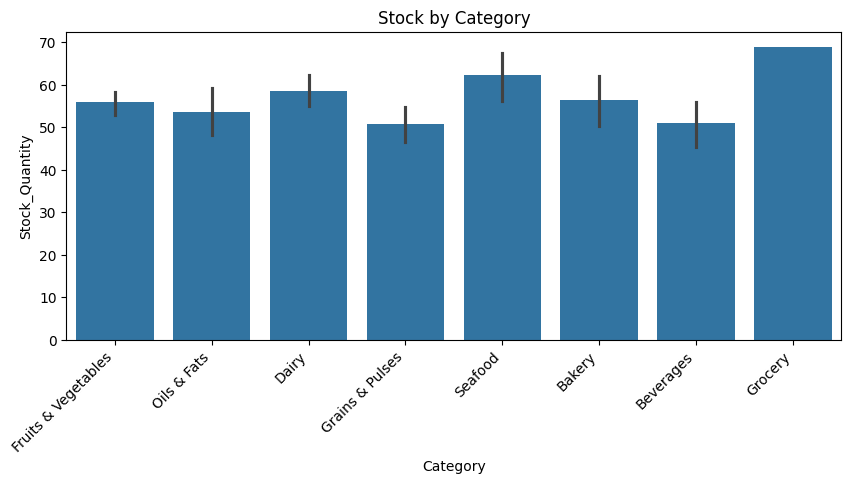

In [6]:
# Quick EDA Checks and Queries

if df is not None:
    display(df.info())
    display(df.head(10))
    if 'Stock_Quantity' in df.columns:
        display(df.sort_values('Stock_Quantity', ascending=False).head(10))
    if set(['Stock_Quantity','Reorder_Level']).issubset(df.columns):
        low = df[df['Stock_Quantity'] <= df['Reorder_Level']]
        print('Items at/below reorder level:', len(low))
        display(low.head(10))
    if 'Expiration_Date' in df.columns:
        soon = df[df['Expiration_Date'] <= (pd.Timestamp.today() + pd.Timedelta(days=30))]
        print('Expiring within 30 days:', len(soon))
        display(soon.head(10))
    if set(['Category','Unit_Price']).issubset(df.columns):
        display(df.groupby('Category')['Unit_Price'].mean().sort_values(ascending=False).head(10))
    # Optional simple plot
    if set(['Category','Stock_Quantity']).issubset(df.columns):
        sns.barplot(x='Category', y='Stock_Quantity', data=df)
        plt.xticks(rotation=45, ha='right')
        plt.title('Stock by Category')
        plt.show()
else:
    print('No data loaded for EDA')


In [7]:
# Save Cleaned Data (CSV/Parquet)

output_dir = 'cleaned'
if df is not None:
    os.makedirs(output_dir, exist_ok=True)
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_out = os.path.join(output_dir, f'Grocery_Inventory_cleaned_{ts}.csv')
    pq_out = os.path.join(output_dir, f'Grocery_Inventory_cleaned_{ts}.parquet')
    df.to_csv(csv_out, index=False)
    try:
        df.to_parquet(pq_out, index=False)
        print('Saved:', csv_out, 'and', pq_out)
    except Exception as e:
        print('Parquet save skipped:', e)
else:
    print('No cleaned data to save')


Saved: cleaned/Grocery_Inventory_cleaned_20251023_172853.csv and cleaned/Grocery_Inventory_cleaned_20251023_172853.parquet


In [14]:
# Run Project Conversion and Pipeline in Colab

if 'google.colab' in sys.modules:
    WORKDIR = '/content/Inventory-Management-Forecasting-using-Machine-Learning'
    %cd $WORKDIR

# Write the uploaded/loaded CSV to repo root if not already
if CSV_PATH is not None:
    target = Path('Grocery_Inventory_new_v1.csv')
    if not target.exists() or Path(CSV_PATH).resolve() != target.resolve():
        try:
            tmp_df = pd.read_csv(CSV_PATH, engine='python')
            tmp_df.to_csv(target, index=False)
            print('Copied CSV into repo root for scripts:', target)
        except Exception as e:
            print('Copy skipped:', e)
else:
    print('CSV not available; you can still run with synthetic data by setting --generate-synthetic')

# Conversion
if Path('Grocery_Inventory_new_v1.csv').exists():
    !python -m scripts.convert_grocery_csv --input "Grocery_Inventory_new_v1.csv" --out-dir data --lead-time 7
else:
    print('Skipping conversion; no CSV found in repo root')

# Choose model
USE_PROPHET = False  # set True to use Prophet (slower, better forecasts)
model_name = 'prophet' if USE_PROPHET else 'lstm_stub'

# Run pipeline
!python -m scripts.train_and_update --data-dir data --output-dir outputs --model $model_name --horizon 30 --plot-examples 3

# Return to the parent if we changed directory
if 'google.colab' in sys.modules:
    %cd -


/content/Inventory-Management-Forecasting-using-Machine-Learning
Converted dataset saved to /content/Inventory-Management-Forecasting-using-Machine-Learning/data
ABC classes saved at outputs/abc_classification.csv
Velocity metrics saved at outputs/velocity_metrics.csv
Reorder recommendations saved at outputs/reorder_recommendations.csv
Forecast plots stored in /content/Inventory-Management-Forecasting-using-Machine-Learning/outputs/plots
Processed 20 products for forecasting
/content


In [9]:
# Display Key Outputs

import glob
from IPython.display import display

reco = Path('outputs/reorder_recommendations.csv')
if reco.exists():
    df_reco = pd.read_csv(reco)
    display(df_reco.head(20))
else:
    print('No reorder_recommendations.csv found yet')

plots_dir = Path('outputs/plots')
if plots_dir.exists():
    pngs = sorted(glob.glob(str(plots_dir / '*.png')))
    print(f'Found {len(pngs)} plots')
    for p in pngs[:5]:
        display(p)
else:
    print('No plots directory found')


No reorder_recommendations.csv found yet
No plots directory found


In [10]:
# Pull Latest Code From GitHub (for VS Code ↔ Colab loop)

if 'google.colab' in sys.modules:
    WORKDIR = '/content/Inventory-Management-Forecasting-using-Machine-Learning'
    %cd $WORKDIR
    !git pull --rebase --autostash
    %cd -
else:
    print('Not in Colab; git pull not needed here')


/content/Inventory-Management-Forecasting-using-Machine-Learning
Already up to date.
/content


In [12]:
# Start Remote Jupyter Server in Colab + Secure Tunnel for VS Code

import secrets
import subprocess
import shlex
import time
import re

if 'google.colab' in sys.modules:
    # Install cloudflared if missing
    !curl -L --output cloudflared.deb https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
    !sudo dpkg -i cloudflared.deb
    print('cloudflared installed')

    # Random token
    TOKEN = secrets.token_hex(16)
    PORT = 9000
    print('Starting Jupyter Server on port', PORT)
    server_cmd = f"jupyter server --ServerApp.token={TOKEN} --ServerApp.allow_origin='*' --no-browser --port={PORT} --NotebookApp.allow_origin='*' --ServerApp.allow_remote_access=True"
    server_proc = subprocess.Popen(shlex.split(server_cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    time.sleep(3)
    print('Starting Cloudflared tunnel...')
    tunnel_proc = subprocess.Popen(['cloudflared', 'tunnel', '--url', f'http://localhost:{PORT}', '--no-autoupdate'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    public_url = None
    t0 = time.time()
    while time.time() - t0 < 60 and public_url is None:
        line = tunnel_proc.stdout.readline().strip() if tunnel_proc.stdout else ''
        if line:
            print(line)
        m = re.search(r'https:\/\/[-a-z0-9]+\.trycloudflare\.com', line)
        if m:
            public_url = m.group(0)
            break
    if public_url:
        print('Public URL:', public_url)
        print('Token:', TOKEN)
    else:
        print('Failed to retrieve public URL; check tunnel logs above')
else:
    print('Not running in Colab; skip remote server')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19.2M  100 19.2M    0     0  19.1M      0  0:00:01  0:00:01 --:--:-- 34.0M
Selecting previously unselected package cloudflared.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack cloudflared.deb ...
Unpacking cloudflared (2025.10.0) ...
Setting up cloudflared (2025.10.0) ...
Processing triggers for man-db (2.10.2-1) ...
cloudflared installed
Starting Jupyter Server on port 9000
Starting Cloudflared tunnel...
2025-10-23T17:30:46Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, 

In [13]:
# Print VS Code Jupyter Server URI and Token

if 'google.colab' in sys.modules:
    try:
        uri = f"{public_url}?token={TOKEN}" if 'public_url' in globals() and public_url else None
        if uri:
            print('Copy this into VS Code:')
            print('Jupyter Server URI:', uri)
            print('Or paste public URL into the Jupyter: Specify Jupyter Server dialog.')
        else:
            print('Public URL not available; please re-run the previous cell to establish the tunnel.')
    except Exception as e:
        print('Error printing URI:', e)
else:
    print('Not in Colab')


Copy this into VS Code:
Jupyter Server URI: https://network-sides-thanks-prefer.trycloudflare.com?token=afb833a380963f278e1e838909734a8e
Or paste public URL into the Jupyter: Specify Jupyter Server dialog.


# VS Code Usage Instructions

1. In VS Code, open your local repository folder.
2. Install the Jupyter extension if you haven't.
3. Command Palette → "Jupyter: Specify Jupyter Server for connections" → "Existing".
4. Paste the URI printed above (it ends with trycloudflare.com and includes ?token=...).
5. Open any local .ipynb and run cells; execution will happen on the Colab kernel.
6. Edit Python files locally; commit/push. In this notebook, run the "Pull Latest Code" cell to sync.


In [ ]:
# Optional: Lightweight Tests for Cleaning Functions

def _assert(name, cond):
    if not cond:
        raise AssertionError(f'Test failed: {name}')
    print('PASS', name)

# Tests
_assert('to_money $53.82', abs(to_money('$53.82') - 53.82) < 1e-6)
_assert('to_percent 089%', abs(to_percent('089%') - 0.89) < 1e-6)
_assert('to_percent -033%', abs(to_percent('-033%') + 0.33) < 1e-6)
_assert('to_date_safe 1/2/2025', str(to_date_safe('1/2/2025').date()) == '2025-01-02')
print('All cleaning tests passed')
